In [2]:
from twelve_api import fetch_forex_dataframe
from features import generate_features
from regime_hmm import fit_hmm_model
from regime_gmm import fit_gmm_model
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = fetch_forex_dataframe("EUR/USD", interval="30min", output_size=1000)
df_feat = generate_features(df)

In [4]:
df_hmm, hmm_metrics = fit_hmm_model(df_feat, n_components=2)
df_gmm, gmm_metrics = fit_gmm_model(df_feat, n_components=2)

In [5]:
print("📈 HMM Metrics:", hmm_metrics)
print("📊 GMM Metrics:", gmm_metrics)

📈 HMM Metrics: {'sharpe': np.float64(0.33), 'total_return': np.float64(3.59), 'max_drawdown': np.float64(-1.36)}
📊 GMM Metrics: {'sharpe': np.float64(0.62), 'total_return': np.float64(2.89), 'max_drawdown': np.float64(-0.17)}


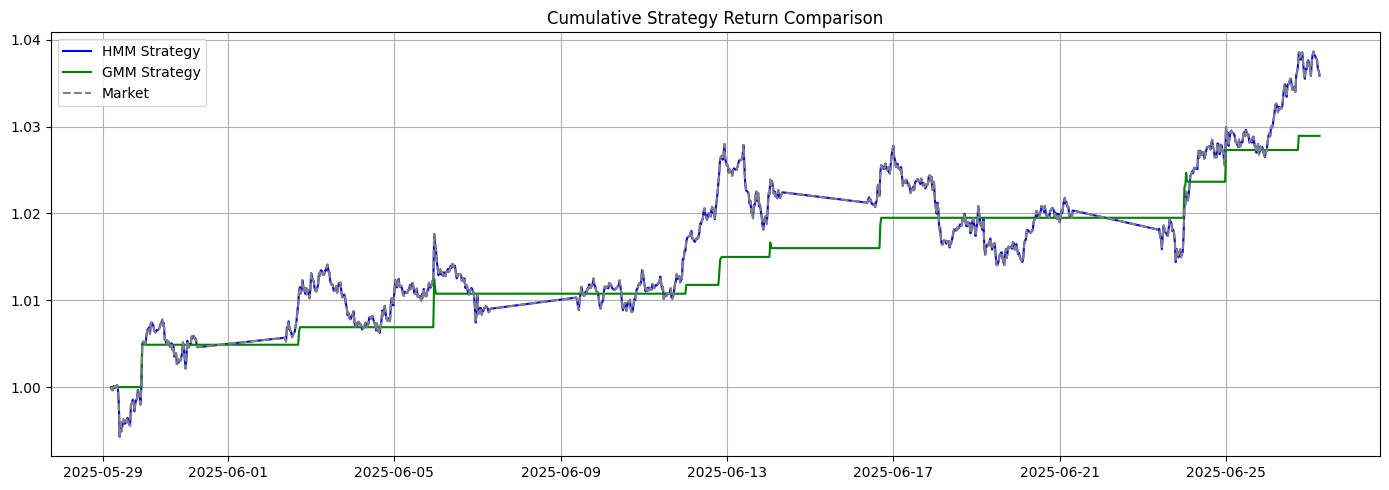

In [6]:
plt.figure(figsize=(14, 5))
plt.plot(df_hmm["datetime"], df_hmm["cumulative_strategy_return"], label="HMM Strategy", color="blue")
plt.plot(df_gmm["datetime"], df_gmm["cumulative_strategy_return"], label="GMM Strategy", color="green")
plt.plot(df_feat["datetime"], (1 + df_feat["return"]).cumprod(), label="Market", color="gray", linestyle="--")
plt.title("Cumulative Strategy Return Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Load the CSV
df = pd.read_csv("eurusd.csv")

# Rename the datetime column
df = df.rename(columns={'Unnamed: 0': 'datetime'})

# Convert datetime to timezone-aware datetime format
df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')

# Drop rows with invalid datetime
df = df.dropna(subset=['datetime'])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Sort by time just in case
df = df.sort_index()



In [7]:
df_4h = df.resample('4h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()


In [8]:
df_4h['Volume'] = 0  # Dummy volume, if none exists

In [15]:
df_4h.to_csv("eurusd_4h.csv")
print(df_4h.head())

                             Open    High     Low   Close  Volume
datetime                                                         
2000-05-30 20:00:00+00:00  0.9302  0.9305  0.9296  0.9296       0
2000-05-31 00:00:00+00:00  0.9297  0.9324  0.9293  0.9315       0
2000-05-31 04:00:00+00:00  0.9315  0.9322  0.9282  0.9305       0
2000-05-31 08:00:00+00:00  0.9310  0.9350  0.9286  0.9310       0
2000-05-31 12:00:00+00:00  0.9309  0.9338  0.9269  0.9279       0


In [10]:
df_4h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31680 entries, 2000-05-30 20:00:00+00:00 to 2020-07-01 04:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    31680 non-null  float64
 1   High    31680 non-null  float64
 2   Low     31680 non-null  float64
 3   Close   31680 non-null  float64
 4   Volume  31680 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.5 MB


In [11]:
print(len(df_4h))

31680


In [21]:
import pandas as pd

df = pd.read_csv("mushi.csv")
print(df.columns)


Index(['Unnamed: 0', 'Open', 'High', 'Low', 'Close'], dtype='object')


In [22]:
import pandas as pd

# Load CSV and parse datetime
df_1min = pd.read_csv("mushi.csv", parse_dates=["Unnamed: 0"])
df_1min = df_1min.rename(columns={"Unnamed: 0": "datetime"})
df_1min.set_index("datetime", inplace=True)

# Check date range and preview
print(df_1min.index.min(), df_1min.index.max())
print(df_1min.head())

# Resample to 4-hour OHLC
df_4h = df_1min.resample("4h").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last"
}).dropna()

print(df_4h.head())
print(len(df_4h))


2000-05-30 17:27:00-05:00 2020-06-30 23:58:00-05:00
                             Open    High     Low   Close
datetime                                                 
2000-05-30 17:27:00-05:00  0.9302  0.9302  0.9302  0.9302
2000-05-30 17:35:00-05:00  0.9304  0.9305  0.9304  0.9305
2000-05-30 17:38:00-05:00  0.9304  0.9304  0.9303  0.9303
2000-05-30 17:43:00-05:00  0.9301  0.9301  0.9300  0.9300
2000-05-30 17:44:00-05:00  0.9298  0.9298  0.9297  0.9297
                             Open    High     Low   Close
datetime                                                 
2000-05-30 16:00:00-05:00  0.9302  0.9305  0.9293  0.9305
2000-05-30 20:00:00-05:00  0.9306  0.9324  0.9306  0.9315
2000-05-31 00:00:00-05:00  0.9315  0.9322  0.9282  0.9300
2000-05-31 04:00:00-05:00  0.9302  0.9350  0.9290  0.9293
2000-05-31 08:00:00-05:00  0.9294  0.9365  0.9269  0.9334
31713


In [23]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd

tv = TvDatafeed()  # or use tv = TvDatafeed(username, password) for premium access

# Determine how many 4-hour bars you need since 2020:
# ~5 years * 365 days * 6 bars/day ≈ 10,950 bars
bars_needed = 11000

df_tv = tv.get_hist(
    symbol='EURUSD',
    exchange='FX_IDC',
    interval=Interval.in_4_hour,
    n_bars=bars_needed
)

print(df_tv.index.min(), df_tv.index.max())
print(df_tv.head(), df_tv.tail())


you are using nologin method, data you access may be limited


2022-01-03 01:00:00 2025-06-30 13:00:00
                            symbol     open     high     low    close  \
datetime                                                                
2022-01-03 01:00:00  FX_IDC:EURUSD  1.13707  1.13790  1.1347  1.13583   
2022-01-03 05:00:00  FX_IDC:EURUSD  1.13582  1.13590  1.1334  1.13380   
2022-01-03 09:00:00  FX_IDC:EURUSD  1.13370  1.13565  1.1333  1.13514   
2022-01-03 13:00:00  FX_IDC:EURUSD  1.13517  1.13663  1.1343  1.13508   
2022-01-03 17:00:00  FX_IDC:EURUSD  1.13505  1.13519  1.1278  1.12835   

                       volume  
datetime                       
2022-01-03 01:00:00   81810.0  
2022-01-03 05:00:00   80958.0  
2022-01-03 09:00:00  188104.0  
2022-01-03 13:00:00  266675.0  
2022-01-03 17:00:00  332748.0                               symbol     open     high      low    close  \
datetime                                                                 
2025-06-27 21:00:00  FX_IDC:EURUSD  1.17016  1.17210  1.16850  1.17162   
20

In [25]:
# Assume df_tv is your TradingView DataFrame
df_tv_clean = df_tv.copy()

# Keep only required columns
df_tv_clean = df_tv_clean[["open", "high", "low", "close", "volume"]]

# Rename to match old dataset
df_tv_clean.columns = ["Open", "High", "Low", "Close", "Volume"]

# Ensure proper dtypes
df_tv_clean["Volume"] = df_tv_clean["Volume"].astype("int64")
df_tv_clean[["Open", "High", "Low", "Close"]] = df_tv_clean[["Open", "High", "Low", "Close"]].astype("float64")

# Confirm datetime index is sorted
df_tv_clean = df_tv_clean.sort_index()

print(df_tv_clean.dtypes)
print(df_tv_clean.index.dtype)



Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
datetime64[ns]


In [26]:
import pandas as pd

# Load original CSV from Kaggle
df_kaggle = pd.read_csv("eurusd_4h.csv", parse_dates=["datetime"], index_col="datetime")

# Check info
print(df_kaggle.dtypes)
print(df_kaggle.index.min(), df_kaggle.index.max())


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
2000-05-30 20:00:00+00:00 2020-07-01 04:00:00+00:00


/var/folders/sf/1g_x5yj53h1ckb3_1mrcvr600000gn/T/ipykernel_1436/2260029172.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_kaggle = pd.read_csv("eurusd_4h.csv", parse_dates=["datetime"], index_col="datetime")


In [30]:
# Force both indexes to be timezone-naive
df_kaggle.index = pd.to_datetime(df_kaggle.index).tz_localize(None)
df_tv_clean.index = pd.to_datetime(df_tv_clean.index).tz_localize(None)

# Merge datasets
df_merged = pd.concat([df_kaggle, df_tv_clean])

# Remove duplicates and sort
df_merged = df_merged[~df_merged.index.duplicated(keep='first')]
df_merged = df_merged.sort_index()

# Optional: Save to file
df_merged.to_csv("eurusd_4h_combined_2000_2025.csv")

# Confirm final range
print(df_merged.index.min(), df_merged.index.max())


2000-05-30 20:00:00 2025-06-30 13:00:00


In [35]:
import pandas as pd

# Load the H4 data
df = pd.read_csv("GBPUSD_PERIOD_H4.csv")

# Combine Date and Time into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%Y.%m.%d %H:%M")

# Set datetime as index
df.set_index('datetime', inplace=True)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Drop Ticker, Date, Time

df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]

print(df.dtypes)
print(df.index.min(), df.index.max())
print(df.head())


# Preview structure
print(df.columns)
print(df.head())

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
1993-05-12 00:00:00 2023-06-08 08:00:00
              Open    High     Low   Close  Volume
datetime                                          
1993-05-12  1.5370  1.5445  1.5290  1.5338    2781
1993-05-13  1.5328  1.5360  1.5180  1.5225    2571
1993-05-14  1.5228  1.5415  1.5200  1.5387    2711
1993-05-17  1.5365  1.5460  1.5309  1.5355    2921
1993-05-18  1.5350  1.5380  1.5237  1.5365    2711
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
              Open    High     Low   Close  Volume
datetime                                          
1993-05-12  1.5370  1.5445  1.5290  1.5338    2781
1993-05-13  1.5328  1.5360  1.5180  1.5225    2571
1993-05-14  1.5228  1.5415  1.5200  1.5387    2711
1993-05-17  1.5365  1.5460  1.5309  1.5355    2921
1993-05-18  1.5350  1.5380  1.5237  1.5365    2711


In [37]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd

# Initialize without login
tv = TvDatafeed()

# Fetch GBP/USD 4-hour data
df_tv_gbp = tv.get_hist(
    symbol='GBPUSD',
    exchange='FX_IDC',
    interval=Interval.in_4_hour,
    n_bars=5000  # ~2-3 years of 4H data
)

# Preview
print(df_tv_gbp.head())
print(df_tv_gbp.tail())

                            symbol    open    high     low   close    volume
datetime                                                                    
2022-04-20 09:00:00  FX_IDC:GBPUSD  1.3029  1.3042  1.2994  1.3031  296712.0
2022-04-20 13:00:00  FX_IDC:GBPUSD  1.3030  1.3066  1.3028  1.3052  337180.0
2022-04-20 17:00:00  FX_IDC:GBPUSD  1.3051  1.3065  1.3032  1.3057  315049.0
2022-04-20 21:00:00  FX_IDC:GBPUSD  1.3057  1.3071  1.3051  1.3061  165703.0
2022-04-21 01:00:00  FX_IDC:GBPUSD  1.3060  1.3074  1.3044  1.3054  171901.0
                            symbol    open    high     low   close    volume
datetime                                                                    
2025-06-27 21:00:00  FX_IDC:GBPUSD  1.3691  1.3722  1.3680  1.3714  118945.0
2025-06-30 01:00:00  FX_IDC:GBPUSD  1.3717  1.3729  1.3707  1.3719  109562.0
2025-06-30 05:00:00  FX_IDC:GBPUSD  1.3719  1.3741  1.3708  1.3728  113248.0
2025-06-30 09:00:00  FX_IDC:GBPUSD  1.3728  1.3738  1.3688  1.3694  210543.0

In [38]:
# Step 2A: Drop the 'symbol' column
df_tv_gbp = df_tv_gbp.drop(columns=['symbol'])

# Step 2B: Rename columns to match format
df_tv_gbp.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Step 2C: Ensure datetime index is timezone-naive
df_tv_gbp.index = pd.to_datetime(df_tv_gbp.index).tz_localize(None)

# Final check
print(df_tv_gbp.dtypes)
print(df_tv_gbp.head())

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
                       Open    High     Low   Close    Volume
datetime                                                     
2022-04-20 09:00:00  1.3029  1.3042  1.2994  1.3031  296712.0
2022-04-20 13:00:00  1.3030  1.3066  1.3028  1.3052  337180.0
2022-04-20 17:00:00  1.3051  1.3065  1.3032  1.3057  315049.0
2022-04-20 21:00:00  1.3057  1.3071  1.3051  1.3061  165703.0
2022-04-21 01:00:00  1.3060  1.3074  1.3044  1.3054  171901.0


In [40]:
# STEP 1: Ensure both indices are datetime and timezone-naive
df.index = pd.to_datetime(df.index).tz_localize(None)
df_tv_gbp.index = pd.to_datetime(df_tv_gbp.index).tz_localize(None)

# STEP 2: Ensure column names match
df_tv_gbp = df_tv_gbp.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})
df_tv_gbp = df_tv_gbp[['Open', 'High', 'Low', 'Close', 'Volume']]  # Drop symbol if present

# STEP 3: Concatenate both datasets
df_gbp_merged = pd.concat([df, df_tv_gbp])

# STEP 4: Remove duplicates and sort by datetime
df_gbp_merged = df_gbp_merged[~df_gbp_merged.index.duplicated(keep='first')]
df_gbp_merged = df_gbp_merged.sort_index()

# STEP 5: Save merged data
df_gbp_merged.to_csv("gbpusd_4h_combined_1993_2025.csv")

# Confirm full datetime range
print(df_gbp_merged.index.min(), df_gbp_merged.index.max())



1993-05-12 00:00:00 2025-06-30 13:00:00


In [46]:
import pandas as pd

# Load the tab-separated data
df = pd.read_csv("usdjpy.csv", sep='\t')

# Rename columns to remove < > and lowercase
df.columns = [col.strip('<>').lower() for col in df.columns]

# Combine date and time into a datetime object
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Keep only OHLCV columns (volume = tickvol)
df = df[['open', 'high', 'low', 'close', 'tickvol']]
df.rename(columns={'tickvol': 'volume'}, inplace=True)

# Sort by datetime and drop duplicates
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]



# Preview cleaned structure
print(df.dtypes)
print(df.index.min(), df.index.max())
print(df.head())

open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object
2010-01-04 00:00:00 2020-12-31 18:00:00
                       open    high     low   close  volume
datetime                                                   
2010-01-04 00:00:00  92.918  92.998  92.690  92.737    1310
2010-01-04 01:00:00  92.738  92.952  92.738  92.890    2160
2010-01-04 02:00:00  92.888  93.060  92.883  92.973    2028
2010-01-04 03:00:00  92.970  92.970  92.835  92.862    1567
2010-01-04 04:00:00  92.861  92.908  92.712  92.746    1235


In [48]:
# Resample to 4-hour OHLCV format
df_4h = df.resample('4h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# Capitalize column names for consistency
df_4h.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Final check
print(df_4h.dtypes)
print(df_4h.index.min(), df_4h.index.max())
print(df_4h.head())


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
2010-01-04 00:00:00 2020-12-31 16:00:00
                       Open    High     Low   Close  Volume
datetime                                                   
2010-01-04 00:00:00  92.918  93.060  92.690  92.862    7065
2010-01-04 04:00:00  92.861  93.050  92.712  93.039    5700
2010-01-04 08:00:00  93.045  93.206  92.717  92.931    8860
2010-01-04 12:00:00  92.930  92.937  92.477  92.629    7897
2010-01-04 16:00:00  92.622  92.692  92.181  92.603    8018


In [54]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd

# No login needed
tv = TvDatafeed()

# Fetch USDJPY data from 2021 to now (4H timeframe)
df_tv_usdjpy = tv.get_hist(
    symbol='USDJPY',
    exchange='FX_IDC',
    interval=Interval.in_4_hour,
    n_bars=100000  # Ensures we get as much as possible
)

# Rename columns to match old format
df_tv_usdjpy = df_tv_usdjpy.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

# Drop 'symbol' column
df_tv_usdjpy = df_tv_usdjpy.drop(columns=['symbol'])

# Ensure datetime index is timezone-naive
df_tv_usdjpy.index = pd.to_datetime(df_tv_usdjpy.index).tz_localize(None)

# Preview
print(df_tv_usdjpy.head())
print(df_tv_usdjpy.index.min(), df_tv_usdjpy.index.max())

                        Open     High     Low    Close    Volume
datetime                                                        
2022-01-03 01:00:00  115.107  115.292  115.01  115.207  103408.0
2022-01-03 05:00:00  115.213  115.316  115.17  115.307   82401.0
2022-01-03 09:00:00  115.310  115.362  115.12  115.176  152478.0
2022-01-03 13:00:00  115.172  115.177  114.91  115.143  215721.0
2022-01-03 17:00:00  115.148  115.367  115.11  115.314  259590.0
2022-01-03 01:00:00 2025-06-30 13:00:00


In [55]:
# Merge the two datasets
df_usdjpy_merged = pd.concat([df_4h, df_tv_usdjpy])

# Remove any duplicate datetime entries, keep the first occurrence
df_usdjpy_merged = df_usdjpy_merged[~df_usdjpy_merged.index.duplicated(keep='first')]

# Sort chronologically
df_usdjpy_merged = df_usdjpy_merged.sort_index()

# Final check
print(df_usdjpy_merged.index.min(), df_usdjpy_merged.index.max())
print(df_usdjpy_merged.head())
print(df_usdjpy_merged.tail())

# Optional: Save to CSV
df_usdjpy_merged.to_csv("usdjpy_4h_2010_2025.csv")


2010-01-04 00:00:00 2025-06-30 13:00:00
                       Open    High     Low   Close  Volume
datetime                                                   
2010-01-04 00:00:00  92.918  93.060  92.690  92.862  7065.0
2010-01-04 04:00:00  92.861  93.050  92.712  93.039  5700.0
2010-01-04 08:00:00  93.045  93.206  92.717  92.931  8860.0
2010-01-04 12:00:00  92.930  92.937  92.477  92.629  7897.0
2010-01-04 16:00:00  92.622  92.692  92.181  92.603  8018.0
                        Open     High      Low    Close    Volume
datetime                                                         
2025-06-27 21:00:00  144.732  144.850  144.584  144.615  148135.0
2025-06-30 01:00:00  144.420  144.764  144.241  144.324  182705.0
2025-06-30 05:00:00  144.319  144.331  143.790  143.908  170403.0
2025-06-30 09:00:00  143.903  144.268  143.772  144.265  259083.0
2025-06-30 13:00:00  144.259  144.495  144.149  144.376  154280.0


In [61]:
import pandas as pd

# Step 1: Load CSV, skip the problematic header row
df = pd.read_csv("AUDUSD.csv", skiprows=1, header=None, names=[
    "ticker", "date", "time", "open", "high", "low", "close", "volume"
], dtype={
    "ticker": str,
    "date": str,
    "time": str,
    "open": float,
    "high": float,
    "low": float,
    "close": float,
    "volume": float
}, low_memory=False)

# Step 2: Combine date and time into datetime
df['datetime'] = pd.to_datetime(
    df['date'] + df['time'].str.zfill(6),
    format="%Y%m%d%H%M%S"
)
df.set_index('datetime', inplace=True)

# Step 3: Keep only OHLCV columns
df = df[['open', 'high', 'low', 'close', 'volume']]
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]

# Step 4: Resample to 4-hour OHLCV format
df_4h = df.resample('4h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# Step 5: Rename columns to consistent format
df_4h.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Save cleaned 4-hour AUDUSD data to CSV
df_4h.to_csv("AUDUSD_4H_cleaned_2001_2023.csv")

print("✅ Saved to AUDUSD_4H_cleaned_2001_2023.csv")


# Step 6: Final preview
print(df_4h.dtypes)
print(df_4h.index.min(), df_4h.index.max())
print(df_4h.head())


✅ Saved to AUDUSD_4H_cleaned_2001_2023.csv
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
2001-01-02 20:00:00 2023-09-29 16:00:00
                       Open    High     Low   Close  Volume
datetime                                                   
2001-01-02 20:00:00  0.5617  0.5622  0.5614  0.5622   156.0
2001-01-03 00:00:00  0.5618  0.5651  0.5618  0.5636   744.0
2001-01-03 04:00:00  0.5638  0.5646  0.5625  0.5630   780.0
2001-01-03 08:00:00  0.5630  0.5648  0.5629  0.5641   804.0
2001-01-03 12:00:00  0.5642  0.5652  0.5614  0.5624   868.0


In [64]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd

# Initialize with nologin
tv = TvDatafeed()

# Fetch AUDUSD data from Oct 1, 2023 to today (assumed June 30, 2025)
df_tv_audusd = tv.get_hist(symbol='AUDUSD', exchange='FX_IDC', interval=Interval.in_4_hour,
                           n_bars=10000)  # Will be trimmed by date range below

# Filter just from October 2023 onward
df_tv_audusd = df_tv_audusd[df_tv_audusd.index >= '2023-10-01']

# Drop the 'symbol' column
df_tv_audusd = df_tv_audusd.drop(columns=['symbol'])

# Rename columns to match the format of the historical data
df_tv_audusd = df_tv_audusd.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

# Ensure datetime index is timezone-naive
df_tv_audusd.index = pd.to_datetime(df_tv_audusd.index).tz_localize(None)

# Sort index just in case
df_tv_audusd = df_tv_audusd.sort_index()

# Final preview
print(df_tv_audusd.dtypes)
print(df_tv_audusd.index.min(), df_tv_audusd.index.max())
print(df_tv_audusd.head())



Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
2023-10-02 01:00:00 2025-06-30 17:00:00
                        Open     High      Low    Close    Volume
datetime                                                         
2023-10-02 01:00:00  0.64306  0.64450  0.64263  0.64286  172491.0
2023-10-02 05:00:00  0.64286  0.64304  0.63933  0.63959  138926.0
2023-10-02 09:00:00  0.63958  0.64260  0.63941  0.63969  232944.0
2023-10-02 13:00:00  0.63969  0.64016  0.63748  0.63778  251871.0
2023-10-02 17:00:00  0.63772  0.63907  0.63625  0.63694  364977.0


In [66]:
# Load historical cleaned data (if not already in memory)
df_old = pd.read_csv("AUDUSD_4H_cleaned_2001_2023.csv", parse_dates=['datetime'], index_col='datetime')

# Confirm dtypes match (just to be safe)
df_old = df_old.astype({
    'Open': 'float64',
    'High': 'float64',
    'Low': 'float64',
    'Close': 'float64',
    'Volume': 'float64'
})

# Combine old + recent data
df_merged = pd.concat([df_old, df_tv_audusd])

# Drop duplicates based on index
df_merged = df_merged[~df_merged.index.duplicated(keep='first')]

# Sort by time
df_merged = df_merged.sort_index()

# Preview
print(df_merged.index.min(), df_merged.index.max())
print(df_merged.tail())
df_merged.to_csv("AUDUSD_4H_2001_2025_merged.csv")
print("✅ Final merged AUDUSD data saved to AUDUSD_4H_2001_2025_merged.csv")



2001-01-02 20:00:00 2025-06-30 17:00:00
                        Open     High      Low    Close    Volume
datetime                                                         
2025-06-30 01:00:00  0.65337  0.65434  0.65244  0.65335  106472.0
2025-06-30 05:00:00  0.65332  0.65528  0.65273  0.65500  110979.0
2025-06-30 09:00:00  0.65498  0.65503  0.65214  0.65244  161593.0
2025-06-30 13:00:00  0.65244  0.65444  0.65198  0.65437  148247.0
2025-06-30 17:00:00  0.65437  0.65452  0.65360  0.65412    7441.0
✅ Final merged AUDUSD data saved to AUDUSD_4H_2001_2025_merged.csv


In [67]:
import pandas as pd

# Step 1: Load CSV, skip the problematic header row
df = pd.read_csv("NZDUSD.csv", skiprows=1, header=None, names=[
    "ticker", "date", "time", "open", "high", "low", "close", "volume"
], dtype={
    "ticker": str,
    "date": str,
    "time": str,
    "open": float,
    "high": float,
    "low": float,
    "close": float,
    "volume": float
}, low_memory=False)

# Step 2: Combine date and time into datetime
df['datetime'] = pd.to_datetime(
    df['date'] + df['time'].str.zfill(6),
    format="%Y%m%d%H%M%S"
)
df.set_index('datetime', inplace=True)

# Step 3: Keep only OHLCV columns
df = df[['open', 'high', 'low', 'close', 'volume']]
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]

# Step 4: Resample to 4-hour OHLCV format
df_4h = df.resample('4h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# Step 5: Rename columns to consistent format
df_4h.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Save cleaned 4-hour AUDUSD data to CSV
df_4h.to_csv("NZDUSD_4H_cleaned_2001_2023.csv")

print("✅ Saved to NZDUSD_4H_cleaned.csv")


# Step 6: Final preview
print(df_4h.dtypes)
print(df_4h.index.min(), df_4h.index.max())
print(df_4h.head())


✅ Saved to NZDUSD_4H_cleaned.csv
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
2003-01-01 20:00:00 2023-09-29 16:00:00
                       Open    High     Low   Close  Volume
datetime                                                   
2003-01-01 20:00:00  0.5250  0.5251  0.5240  0.5241    68.0
2003-01-02 00:00:00  0.5241  0.5241  0.5221  0.5235   244.0
2003-01-02 04:00:00  0.5239  0.5239  0.5227  0.5232   272.0
2003-01-02 08:00:00  0.5233  0.5252  0.5231  0.5233   340.0
2003-01-02 12:00:00  0.5233  0.5238  0.5215  0.5230   452.0


In [70]:
# Load historical cleaned data (if not already in memory)
df_old = pd.read_csv("NZDUSD_4H_cleaned_2001_2023.csv", parse_dates=['datetime'], index_col='datetime')

# Confirm dtypes match (just to be safe)
df_old = df_old.astype({
    'Open': 'float64',
    'High': 'float64',
    'Low': 'float64',
    'Close': 'float64',
    'Volume': 'float64'
})

# Combine old + recent data
df_merged = pd.concat([df_old, df_tv_audusd])

# Drop duplicates based on index
df_merged = df_merged[~df_merged.index.duplicated(keep='first')]

# Sort by time
df_merged = df_merged.sort_index()

# Preview
print(df_merged.index.min(), df_merged.index.max())
print(df_merged.tail())
df_merged.to_csv("NZDUSD_4H_merged.csv")
print("✅ Final merged AUDUSD data saved to NZDUSD_4H_merged.csv")

2003-01-01 20:00:00 2025-06-30 17:00:00
                        Open     High      Low    Close    Volume
datetime                                                         
2025-06-30 01:00:00  0.65337  0.65434  0.65244  0.65335  106472.0
2025-06-30 05:00:00  0.65332  0.65528  0.65273  0.65500  110979.0
2025-06-30 09:00:00  0.65498  0.65503  0.65214  0.65244  161593.0
2025-06-30 13:00:00  0.65244  0.65444  0.65198  0.65437  148247.0
2025-06-30 17:00:00  0.65437  0.65452  0.65360  0.65412    7441.0
✅ Final merged AUDUSD data saved to NZDUSD_4H_merged.csv


In [5]:
import joblib
import pandas as pd

model = joblib.load('models/xgboost/xgb_model_AUDUSD.pkl')
booster = model.get_booster()
num_features = booster.num_features()
print("Model expects", num_features, "features.")

with open('feature_list_available.txt') as f:
    features = [line.strip() for line in f if line.strip() and not line.startswith('#')]

df = pd.read_csv('enhanced_regime_features.csv')
missing = [f for f in features if f not in df.columns]
print("Missing features:", missing)
print("Feature list length:", len(features))
print("Data has:", len(df.columns), "columns")

Model expects 50 features.
Missing features: []
Feature list length: 46
Data has: 59 columns


In [6]:
  import pandas as pd
  df = pd.read_csv('enhanced_regime_features.csv')
  features = [col for col in df.columns if col not in ['datetime', 'open', 'high', 'low', 'close', 'volume', 'pair', 'actual_return', 'label']]
  print(features)
  print(len(features))

['sma_20', 'ema_20', 'rsi', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'bb_mid', 'support', 'resistance', 'regime_hmm', 'bull_prob_hmm', 'regime_gmm', 'bull_prob_gmm', 'return', 'regime_hmm_vol', 'regime_gmm_vol', 'regime_agreement', 'hmm_regime_duration', 'gmm_regime_duration', 'hmm_regime_change', 'gmm_regime_change', 'regime_change_agreement', 'bull_prob_diff', 'bull_prob_ratio', 'bull_prob_avg', 'bull_prob_hmm_capped', 'bull_prob_hmm_log', 'bull_prob_hmm_sqrt', 'bull_prob_hmm_zscore', 'vol_regime_hmm', 'vol_regime_gmm', 'vol_bull_prob_hmm', 'vol_bull_prob_gmm', 'return_regime_hmm', 'return_regime_gmm', 'return_bull_prob_hmm', 'return_bull_prob_gmm', 'regime_vol_interaction', 'regime_vol_diff', 'bull_prob_hmm_ma5', 'bull_prob_gmm_ma5', 'bull_prob_hmm_std5', 'bull_prob_gmm_std5', 'price_range', 'volume_price_ratio', 'hour', 'day_of_week', 'is_weekend', 'regime_strength_hmm', 'regime_strength_gmm', 'regime_strength_avg']
52
